<a href="https://colab.research.google.com/github/DevBatra05/DeepLearningLab/blob/main/Lab_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Synthetic Image Generation via Generative Adversarial Networks (GANs)


In [1]:
!pip install -q kagglehub

import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# Download dataset
path = kagglehub.dataset_download("l3llff/flowers")
print("Dataset root:", path)

IMAGE_ROOT = os.path.join(path, "flowers")
print("Images folder:", IMAGE_ROOT)
print("Class folders:", os.listdir(IMAGE_ROOT))


Using Colab cache for faster access to the 'flowers' dataset.
Dataset root: /kaggle/input/flowers
Images folder: /kaggle/input/flowers/flowers
Class folders: ['astilbe', 'daffodil', 'black_eyed_susan', 'bellflower', 'common_daisy', 'coreopsis', 'dandelion', 'water_lily', 'carnation', 'calendula', 'california_poppy', 'sunflower', 'tulip', 'rose', 'magnolia', 'iris']


In [3]:
IMG_SIZE   = 64
BATCH_SIZE = 64
LATENT_DIM = 128      # length of noise vector z
AUTOTUNE   = tf.data.AUTOTUNE


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_ROOT,
    label_mode=None,                    # no labels
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Scale images from [0,255] → [-1,1] (because generator uses tanh)
def normalize(images):
    images = tf.cast(images, tf.float32)
    images = (images / 127.5) - 1.0
    return images

dataset = dataset.map(normalize).cache().shuffle(1000).prefetch(AUTOTUNE)


Found 15740 files.


Batch shape: (64, 64, 64, 3)


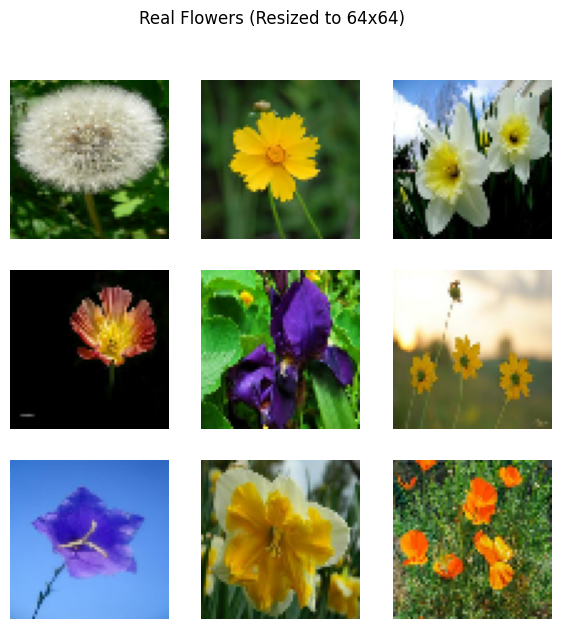

In [5]:
sample_batch = next(iter(dataset))
print("Batch shape:", sample_batch.shape)

plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = (sample_batch[i] + 1.0) / 2.0   # back to [0,1] for display
    plt.imshow(img.numpy())
    plt.axis("off")
plt.suptitle("Real Flowers (Resized to 64x64)")
plt.show()


In [6]:
def build_generator(latent_dim=LATENT_DIM):
    inputs = keras.Input(shape=(latent_dim,))

    x = layers.Dense(8 * 8 * 256, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Reshape((8, 8, 256))(x)     # 8x8

    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", use_bias=False)(x)  # 16x16
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", use_bias=False)(x)   # 32x32
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(32, 4, strides=2, padding="same", use_bias=False)(x)   # 64x64
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    outputs = layers.Conv2D(3, kernel_size=3, padding="same",
                            activation="tanh")(x)

    model = keras.Model(inputs, outputs, name="generator")
    return model

generator = build_generator()
generator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16384)          │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,852,579 (10.88 MB)

 Trainable params: 2,819,363 (10.76 MB)

 Non-trainable params: 33,216 (129.75 KB)

In [7]:
def build_discriminator():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = layers.Conv2D(64, 4, strides=2, padding="same")(inputs)      # 32x32
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding="same")(x)          # 16x16
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding="same")(x)          # 8x8
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1)(x)   # logits (no activation)

    model = keras.Model(inputs, outputs, name="discriminator")
    return model

discriminator = build_discriminator()
discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 676,801 (2.58 MB)

 Trainable params: 676,033 (2.58 MB)

 Non-trainable params: 768 (3.00 KB)

In [8]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

class GAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim=LATENT_DIM, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # ----- 1. Train Discriminator -----
        # Sample random noise and generate fake images
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_images = self.generator(random_latent_vectors, training=True)

        # Discriminator predictions
        with tf.GradientTape() as tape:
            real_logits = self.discriminator(real_images, training=True)
            fake_logits = self.discriminator(fake_images, training=True)

            # Real labels = 1, fake labels = 0
            d_real_loss = self.loss_fn(tf.ones_like(real_logits), real_logits)
            d_fake_loss = self.loss_fn(tf.zeros_like(fake_logits), fake_logits)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # ----- 2. Train Generator -----
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            fake_logits = self.discriminator(generated_images, training=True)

            # Generator wants discriminator to output 1 for fake
            g_loss = self.loss_fn(tf.ones_like(fake_logits), fake_logits)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # ----- Update metrics -----
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}


In [9]:
gan = GAN(generator, discriminator, latent_dim=LATENT_DIM)

gan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    g_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    loss_fn     = cross_entropy
)


In [10]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_images=16, latent_dim=LATENT_DIM):
        self.num_images = num_images
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_images, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1.0) / 2.0  # back to [0,1]

        plt.figure(figsize=(6,6))
        for i in range(self.num_images):
            ax = plt.subplot(4, 4, i+1)
            plt.imshow(generated_images[i].numpy())
            plt.axis("off")
        plt.suptitle(f"Generated Flowers - Epoch {epoch+1}")
        plt.tight_layout()
        plt.show()


Epoch 1/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - d_loss: 0.1825 - g_loss: 6.0300

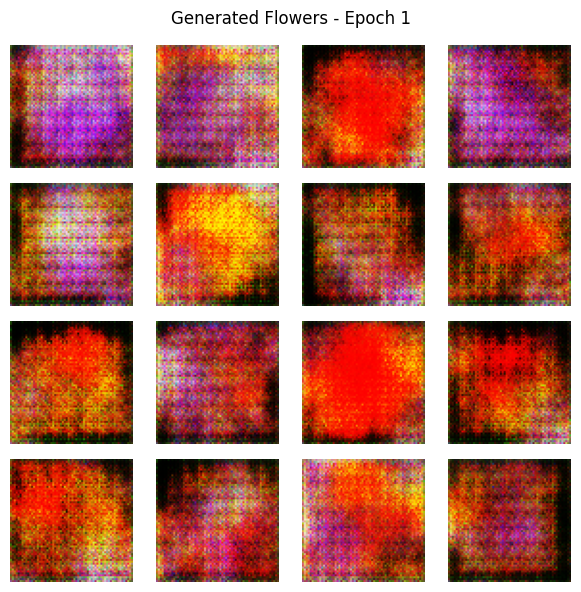

246/246 ━━━━━━━━━━━━━━━━━━━━ 984s 4s/step - d_loss: 0.1826 - g_loss: 6.0265
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - d_loss: 0.4405 - g_loss: 3.1244

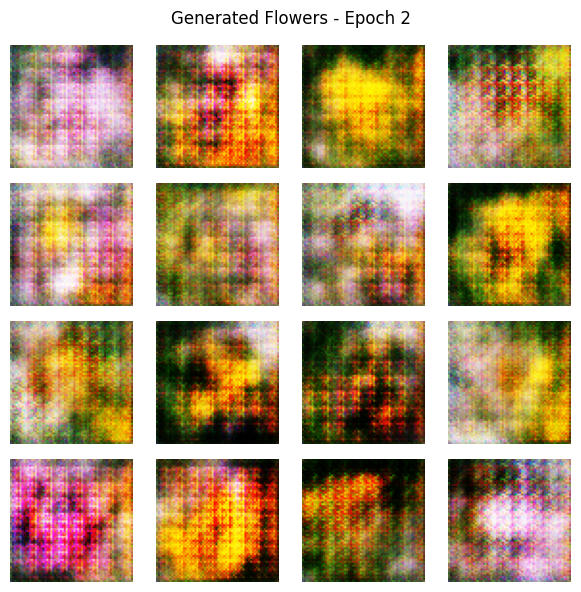

246/246 ━━━━━━━━━━━━━━━━━━━━ 959s 4s/step - d_loss: 0.4402 - g_loss: 3.1247
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - d_loss: 0.3405 - g_loss: 3.6121

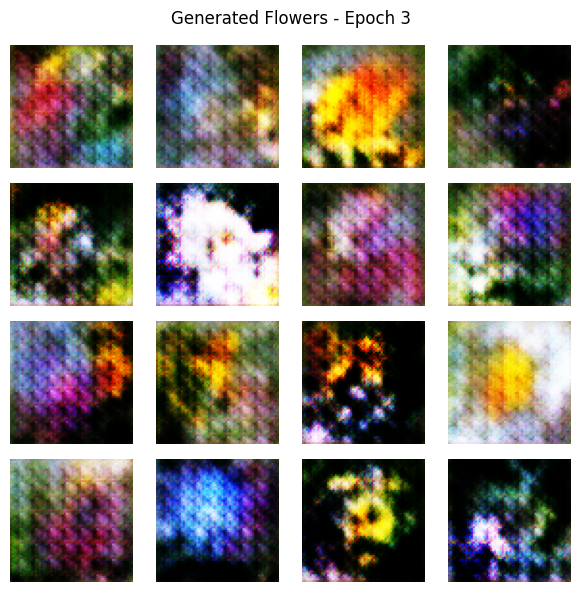

246/246 ━━━━━━━━━━━━━━━━━━━━ 965s 4s/step - d_loss: 0.3405 - g_loss: 3.6113
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - d_loss: 0.3784 - g_loss: 3.1244

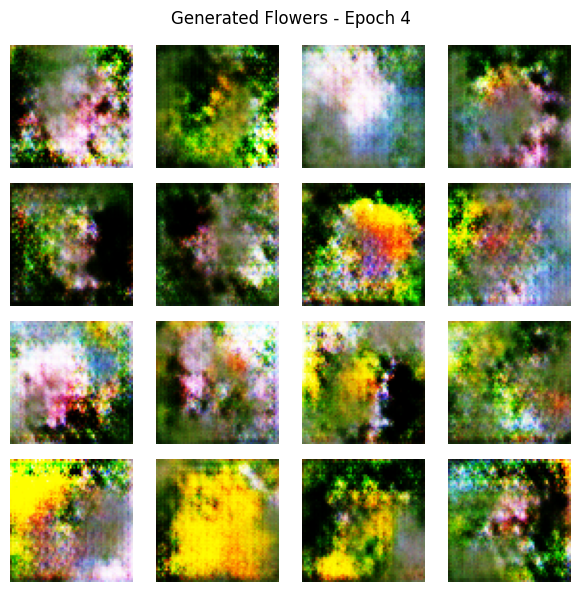

246/246 ━━━━━━━━━━━━━━━━━━━━ 986s 4s/step - d_loss: 0.3783 - g_loss: 3.1243
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - d_loss: 0.4464 - g_loss: 2.7106

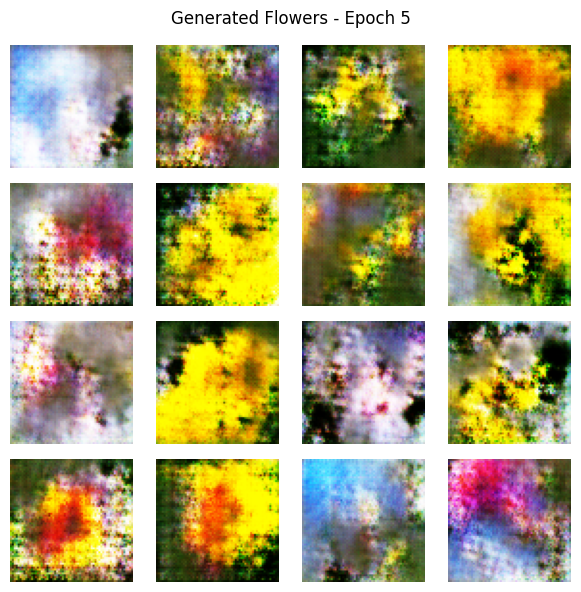

246/246 ━━━━━━━━━━━━━━━━━━━━ 971s 4s/step - d_loss: 0.4464 - g_loss: 2.7103


In [13]:
EPOCHS = 5

history = gan.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_images=16, latent_dim=LATENT_DIM)]
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


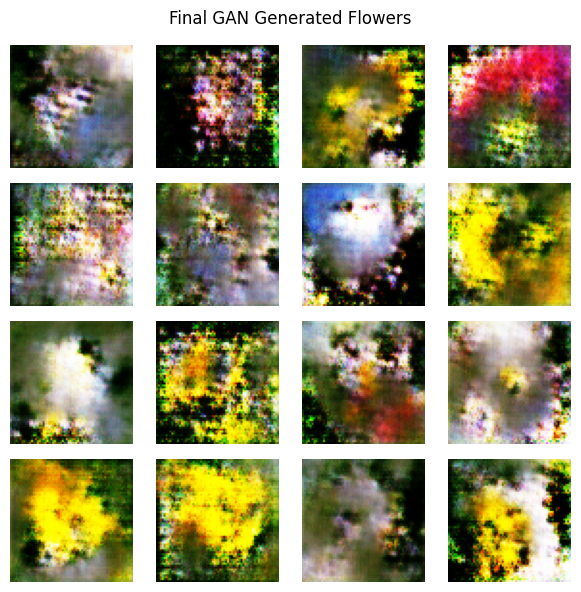

In [14]:
num_samples = 16
random_latent_vectors = tf.random.normal(shape=(num_samples, LATENT_DIM))
generated_images = generator.predict(random_latent_vectors)
generated_images = (generated_images + 1.0) / 2.0  # back to [0,1]

plt.figure(figsize=(6,6))
for i in range(num_samples):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.suptitle("Final GAN Generated Flowers")
plt.tight_layout()
plt.show()


In [15]:
generator.save("flowers_dcgan_generator.h5")
discriminator.save("flowers_dcgan_discriminator.h5")
